# Advanced Lane Finding Project
## The goals / steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.<br />


In [2]:
#First the imports
import numpy as np
import cv2
import glob #it didn't work with me for some reason in the workspace but let's keep it just in case
import matplotlib.pyplot as plt
import matplotlib.image as mpimg #i will try to use the plotting method of the previous project

%matplotlib inline


## Now I'll compute the camera calibration using chessboard images

In [3]:

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
nx=9 #number of corners horizontally 
ny=6 #number of corners vertically
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.

objpoints = [] # 3d points in real world space, but the z coordinate has to always be zero, because the pictures were taken on a flat surface
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images

images=[]
for i in range(1,21):
    s='/home/workspace/CarND-Advanced-Lane-Lines/camera_cal/calibration'+str(i)+'.jpg'
    #print(s)
    img=mpimg.imread(s)
    images.append(img)
    
    #plt.imshow(img)
#print(len(images))

# Step through the list and search for chessboard corners

for img in images:
    #First transform to grayScale because this is what the cv2 calibration functions deal with
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp) 
        imgpoints.append(corners)
        #print(corners)

        # Draw and display the corners -Not an important step, just for testing and visualization
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #plt.imshow(img)
        
#NOW i have the corners of all the distorted images, it's time to calculate the calibration matrices

gray=cv2.cvtColor(images[1],cv2.COLOR_BGR2GRAY)
ret,mtx,dist,rvecs,tvecs=cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)

#Now that i have the matrices i want to test the undistortion correction, so i'll try it on one of the test images
# The output of my trials will be saved in this path ''
"""
testImageInput=mpimg.imread('/home/workspace/CarND-Advanced-Lane-Lines/camera_cal/calibration10.jpg')
testImageOutput= cv2.undistort(testImageInput,mtx,dist,None,mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(testImageInput)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(testImageOutput)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

mpimg.imsave('/home/workspace/CarND-Advanced-Lane-Lines/test_images/undistort-output.jpg',testImageOutput )
"""
#Now that the testing worked fine, it means we have a good distortion correction matrices
#Each time i want to undistort a Frame, i call the cv2.undistort(frameImage,mtx,dist,None,mtx) and it returns
#the undistorted frame
#NOW let's head to the next step,Color Space transformation


"\ntestImageInput=mpimg.imread('/home/workspace/CarND-Advanced-Lane-Lines/camera_cal/calibration10.jpg')\ntestImageOutput= cv2.undistort(testImageInput,mtx,dist,None,mtx)\n\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))\nf.tight_layout()\nax1.imshow(testImageInput)\nax1.set_title('Original Image', fontsize=50)\nax2.imshow(testImageOutput)\nax2.set_title('Undistorted Image', fontsize=50)\nplt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)\n\nmpimg.imsave('/home/workspace/CarND-Advanced-Lane-Lines/test_images/undistort-output.jpg',testImageOutput )\n"

## Now transform images into a suitable Color Space

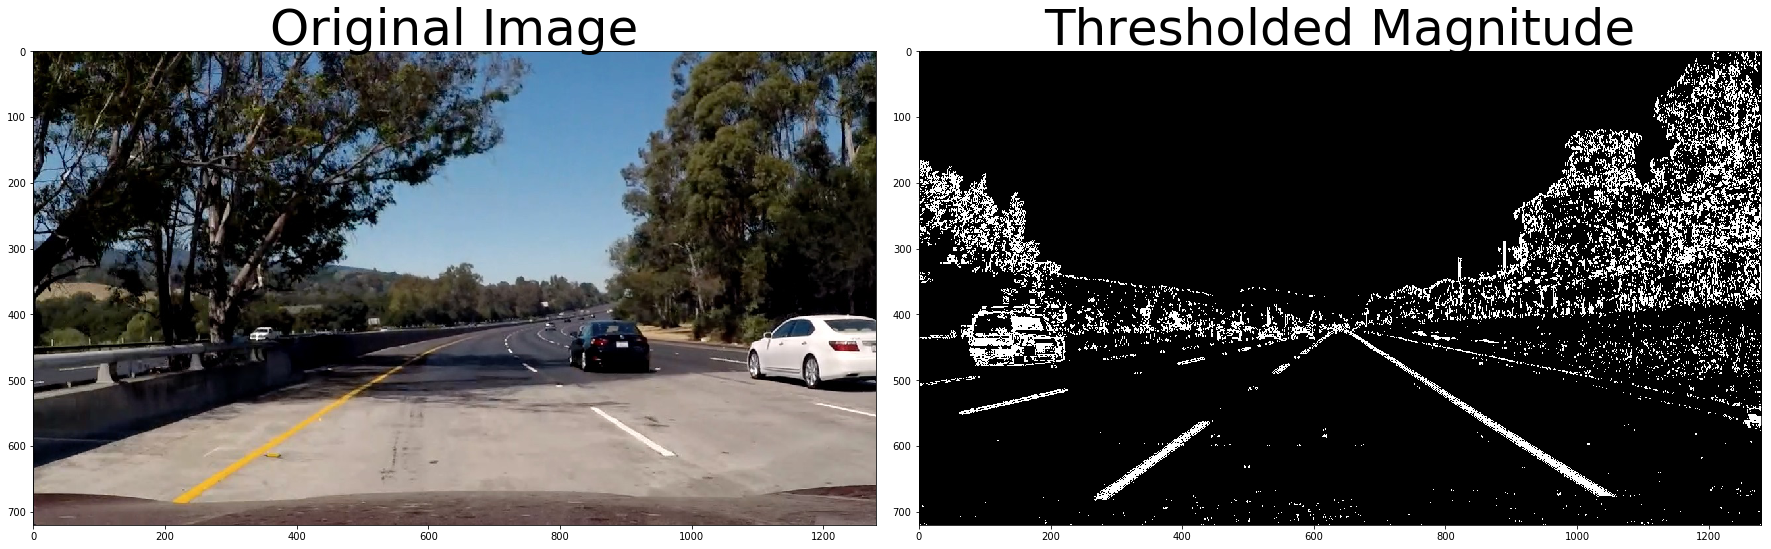

In [47]:
#I'm going to transform the images into HLS: Hue, Light, Saturation Color Space because i'm expecting the images
#to be in difficult light conditions, so if we exclude the Light from HLS, we should find it easy to know the
# color of objects in the image
#Note to self: i made this step before the perspective transform because i just thought to transform a part of the
#image that's already undistorted and in binary form, is a nicer thing to do.. idk..


#Basically i'm going to get the gray scale,and the S channel from the HSL space and combine them to form a binray image

#First upload all the images 
testImages=[]
testImages.append(mpimg.imread('/home/workspace/CarND-Advanced-Lane-Lines/test_images/straight_lines1.jpg'))
testImages.append(mpimg.imread('/home/workspace/CarND-Advanced-Lane-Lines/test_images/straight_lines2.jpg'))

for i in range(1,7):
    s='/home/workspace/CarND-Advanced-Lane-Lines/test_images/test'+str(i)+'.jpg'
    #print(s)
    img=mpimg.imread(s)
    testImages.append(img)
    
#print(len(testImages))

def get_abs_mag_dir_binary(image, abs_thresh=(0, 255),mag_thresh=(0, 255),dir_thresh=(0, np.pi/2),sobel_kernel=3):
    
    ###First The magnitude part
    #First grayScale
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    #Get the "derivative" in the x direction
    sobelx=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely=cv2.Sobel(gray,cv2.CV_64F, 0,1,ksize=sobel_kernel)
    
    #idk if getting the mag is better or if getting sobelx only is better, but will try out everything, so let's see 
    mag= np.sqrt((sobelx**2)+(sobely**2))
    magScaled= np.uint8(mag*255/np.max(mag))
    
    magBinaryOutput= np.zeros_like(magScaled)
    magBinaryOutput[(magScaled>=mag_thresh[0]) & (magScaled<=mag_thresh[1])]=1
    
    
    ##Second For the Direction part
    
    sobelx_abs=np.absolute(sobelx)
    sobely_abs=np.absolute(sobely)  
    
    
    direction=np.arctan2(sobely_abs,sobelx_abs) 
    
    dirBinaryOutput=np.zeros_like(direction)
    dirBinaryOutput[(direction>=dir_thresh[0]) & (direction<=dir_thresh[1])]=1 
    
    #Finally for the ABSOLUTE PART
    abs_scaled =np.uint8(255*sobelx_abs/np.max(sobelx_abs)) 
    absBinary= np.zeros_like(abs_scaled)
    absBinary[(abs_scaled>= abs_thresh[0]) & (abs_scaled <= abs_thresh[1])] =1
    
    #NOW COMBINE
    combined = np.zeros_like(dirBinaryOutput)
    #combined[(absBinary == 1) |((magBinaryOutput == 1) & (dirBinaryOutput == 1))] = 1
    #combined[(absBinary == 1) &(  (dirBinaryOutput == 1))] = 1
    combined[(absBinary == 1) |((magBinaryOutput == 1) )] = 1


    
    
    return absBinary


def get_s_binary(img, s_thresh=(0, 255)):
    
    hls=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    #I remember from the quizes and my trials that the S channel was the best in different lighting conditions so..
    s=hls[:,:,2]
    

    binary_output=np.zeros_like(s)
    binary_output[(s>s_thresh[0]) & (s<=s_thresh[1])]=1 #2
    
    
    return binary_output

#TESTING
"""
outt=get_abs_mag_dir_binary(testImages[6],abs_thresh=(20,100),mag_thresh=(200, 255),dir_thresh=(0.7, 1.3))
#outt=get_s_binary(testImages[6],s_thresh=(165,255))
#plt.imshow(outt)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(testImages[6])
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(outt, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
"""



#Now let's define a function that transforms each frame/image into my combined binary fram/image
def getCombinedBinary(image,Abs_Thresh=(15,100),Mag_Thresh=(100, 255),Dir_Thresh=(0.7, 1.3),S_Thresh=(165,255),Sobel_Kernel=3):
    """
    #s_thresh=(170, 255), sx_thresh=(20, 100)
    #First grayScale
    gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    #Get the "derivative" in the x direction
    sobelx=cv2.Sobel(gray,cv2.CV_64F, 1,0,ksize=sobel_kernel)
    sobely=cv2.Sobel(gray,cv2.CV_64F, 0,1,ksize=sobel_kernel)
    
    #idk if getting the mag is better or if getting sobelx only is better, but will try out everything, so let's see 
    mag= np.sqrt((sobelx**2)+(sobely**2))
    magScaled= np.uint8(mag*255/np.max(mag))
    
    magBinaryOutput= np.zeros_like(mag_scaled)
    magBinaryOutput[(mag_scaled>=mag_thresh[0]) & (mag_scaled<=mag_thresh[1])]=1
    """
    outt1=get_abs_mag_dir_binary(image,abs_thresh=Abs_Thresh,mag_thresh=Mag_Thresh,dir_thresh=Dir_Thresh,sobel_kernel=Sobel_Kernel)
    outt2=get_s_binary(image,s_thresh=S_Thresh)
    
    #combined = np.dstack(( np.zeros_like(outt1), outt1, outt2)) * 255
    
    #E7NA WE2FNA YA YOMNA W 3ANDK MOSHKELA FE EL OUTPUT BYTLA3 FE BO23A BEL3ARD KEDA+ MSH 3ARFEN NE3ML DSTACK W HYA SHAKLAHA MOHEMA BTW 
    combined = np.zeros_like(outt2)
    combined[((outt1 == 1) | (outt2 == 1))] = 1

    return combined

#TESTING
outt=getCombinedBinary(testImages[1])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(testImages[6])
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(outt, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
   

#Now we test this pipeline on the 8 images in the examples directory


## Now time for Perspective Transform

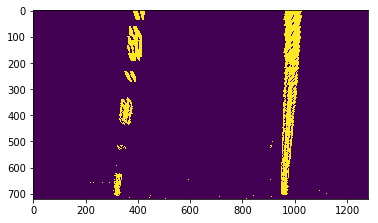

In [48]:
#Let's pick an area that most probably represents a rectangle in the real world 
#Let's define a function for transforming each image
def persp_trans(img):
    img_size=(img.shape[1],img.shape[0])
     
    src=np.float32(
        [[195,img.shape[0]],   #Low_Left
         [1140,img.shape[0]],   #Low_Right
         [550,470],            #Up_Left
         [720,470]])           #Up_Right
    
    offset=300
    
    dst=np.float32(
        [[offset,img.shape[0]],
         [img.shape[1]-offset,img.shape[0]],
         [offset,offset],
         [img.shape[1]-offset,offset]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

#TEST
plt.imshow(persp_trans(outt))
    